In [3]:
import pandas as pd
from tqdm import tqdm
from rdkit import Chem

from massspecgym.tools.murcko_hist import murcko_hist, are_sub_hists
from massspecgym.data.transforms import MolFingerprinter
from massspecgym.data.datasets import MSnDataset
from massspecgym.tools.plots import evaluate_split

In [14]:
# We want to keep only those candidate molecules that do NOT have a Murcko histogram that is “similar” 
def is_similar_to_test_val(candidate_hist, test_val_histograms, k=3, d=4):
    """Return True if candidate_hist is similar to any histogram in test_val_histograms."""
    for tv_hist in test_val_histograms:
        if are_sub_hists(candidate_hist, tv_hist, k=k, d=d):
            return True
    return False

def safe_murcko_hist(smiles):
    """
    Computes the Murcko histogram for the given SMILES string.
    If an error occurs, returns None.
    """
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        return murcko_hist(mol)
    except Exception as e:
        return None

In [2]:
mol_transform = MolFingerprinter(fp_size=2048)
msn_dataset = MSnDataset(pth="/Users/macbook/CODE/Majer:MassSpecGym/data/MSn/20241211_msn_library_pos_all_lib_MSn.mgf",
                         mol_transform=mol_transform,
                         max_allowed_deviation=0.005)
print(len(msn_dataset))

16476


In [3]:
df = msn_dataset.metadata 

In [9]:
df.columns

Index(['charge', 'description', 'formula', 'inchi', 'smiles', 'feature_id',
       'adduct', 'spectype', 'fragmentation_method', 'isolation_window',
       'acquisition', 'instrument_type', 'ims_type', 'ion_source', 'ionmode',
       'dataset_id', 'usi', 'scans', 'precursor_purity', 'quality_chimeric',
       'quality_explained_intensity', 'quality_explained_signals',
       'collision_energy', 'num_peaks', 'compound_name', 'parent_mass',
       'inchi_aux', 'ms_level', 'retention_time', 'principal_investigator',
       'data_collector', 'precursor_mz', 'identifier', 'fold',
       'msn_collision_energies', 'msn_precursor_mzs',
       'msn_fragmentation_methods', 'msn_isolation_windows',
       'other_matched_compounds', 'other_matched_compounds_names', 'comment',
       'inchi_key', 'mol_freq'],
      dtype='object')

In [14]:
print("Original dataset shape:", df.shape)
print("Unique folds:", df['fold'].unique())

Original dataset shape: (183365, 43)
Unique folds: ['test' 'train' 'val']


In [15]:
df_orig_us = df.drop_duplicates(subset=['smiles']).copy()

In [16]:
tqdm.pandas(desc="Original molecules")
df_orig_us['MurckoHist'] = df_orig_us['smiles'].progress_apply(
    lambda s: murcko_hist(Chem.MolFromSmiles(s))
)

Original molecules: 100%|██████████| 13996/13996 [00:04<00:00, 3251.29it/s]


In [17]:
# Select only the molecules belonging to the test and validation folds;
# these are the ones you do NOT want your new candidates to “invade.”
df_test_val = df_orig_us[df_orig_us['fold'].isin(['test', 'val'])].copy()
# Get their Murcko histogram objects
test_val_hists = df_test_val['MurckoHist'].tolist()

# 1M dataset

In [19]:
df_1M = pd.read_csv('/Users/macbook/CODE/Majer:MassSpecGym/data/candidates_generation/MassSpecGym_retrieval_molecules_1M.tsv', 
                    sep='\t')
print("Candidate dataset shape:", df_1M.shape)
print("Candidate dataset columns:", df_1M.columns)

Candidate dataset shape: (1032456, 5)
Candidate dataset columns: Index(['smiles', 'inchi_key_2D', 'inchi', 'formula', 'weight'], dtype='object')


In [20]:
# Compute Murcko Histograms for the Candidates
tqdm.pandas(desc="Candidates")
df_1M['MurckoHist'] = df_1M['smiles'].progress_apply(
    lambda s: murcko_hist(Chem.MolFromSmiles(s))
)
df_1M['MurckoHistStr'] = df_1M['MurckoHist'].astype(str)

Candidates: 100%|██████████| 1032456/1032456 [07:03<00:00, 2435.41it/s]


In [22]:
# Apply the filter: keep candidate rows that are not similar to any test/val histogram.
tqdm.pandas(desc="Filtering candidates")
mask = ~df_1M['MurckoHist'].progress_apply(lambda h: is_similar_to_test_val(h, test_val_hists, k=3, d=4))
df_1M_train = df_1M[mask].copy()

print("Number of candidate molecules kept for train fold:", len(df_1M_train))

# For these candidates, assign fold 'train'
df_1M_train['fold'] = 'train'

Filtering candidates: 100%|██████████| 1032456/1032456 [18:24<00:00, 934.76it/s] 


Number of candidate molecules kept for train fold: 622548


In [23]:
df_orig_small = df[['smiles', 'fold']].copy()
df_candidates_small = df_1M_train[['smiles', 'fold']].copy()

df_combined = pd.concat([df_orig_small, df_candidates_small], ignore_index=True)
print("Combined dataset shape:", df_combined.shape)

Combined dataset shape: (805913, 2)


Computing Morgan fingerprints for training set...
Computing Morgan fingerprints for validation set...
Computing maximum Tanimoto similarities for validation set...
Plotting histogram of maximum Tanimoto similarities...


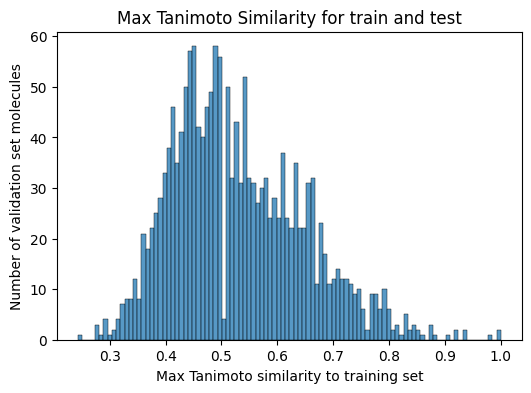

In [24]:
max_tanimoto_train_test = evaluate_split(
    df_split=df_combined,
    train_fold='train',
    val_fold='test',
    smiles_col='smiles',
    radius=2,
    n_bits=2048
)

Computing Morgan fingerprints for training set...
Computing Morgan fingerprints for validation set...
Computing maximum Tanimoto similarities for validation set...
Plotting histogram of maximum Tanimoto similarities...


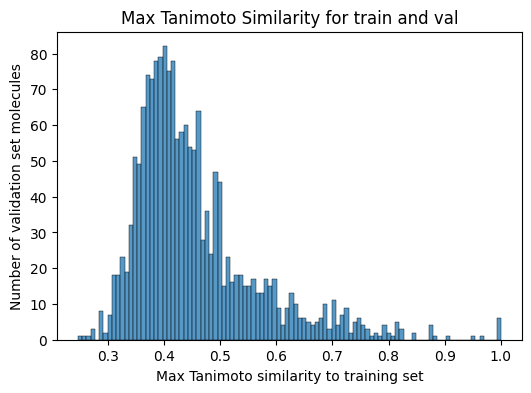

In [25]:
max_tanimoto_train_val = evaluate_split(
    df_split=df_combined,
    train_fold='train',
    val_fold='val',
    smiles_col='smiles',
    radius=2,
    n_bits=2048
)

In [26]:
df_orig_train = df_orig_us[df_orig_us['fold'] == 'train'].copy()
df_orig_train = df_orig_train[['smiles', 'fold', 'MurckoHist']]

In [28]:
df_combined_train = pd.concat([df_1M_train, df_orig_train], ignore_index=True)

In [30]:
print("Combined training dataset shape:", df_combined_train.shape)

Combined training dataset shape: (633087, 8)


In [31]:
output_filename = "/Users/macbook/CODE/Majer:MassSpecGym/data/MSn/20241211_1M_murcko_train_smiles.tsv"
# df_combined_train.to_csv(output_filename, sep="\t", index=False)
print(f"Saved combined train smiles to {output_filename}")

Saved combined train smiles to /Users/macbook/CODE/Majer:MassSpecGym/data/MSn/20241211_1M_murcko_train_smiles.tsv


# 4M Dataset

In [15]:
df = msn_dataset.metadata
df_orig_us = df.drop_duplicates(subset=['smiles']).copy()

In [16]:
tqdm.pandas(desc="Original molecules")
df_orig_us['MurckoHist'] = df_orig_us['smiles'].progress_apply(
    lambda s: murcko_hist(Chem.MolFromSmiles(s))
)

df_test_val = df_orig_us[df_orig_us['fold'].isin(['test', 'val'])].copy()
# Get their Murcko histogram objects 
test_val_hists = df_test_val['MurckoHist'].tolist()

Original molecules: 100%|██████████| 13996/13996 [02:01<00:00, 115.66it/s]


In [21]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=8)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [22]:
df_4M = pd.read_csv('/Users/macbook/CODE/Majer:MassSpecGym/data/candidates_generation/MassSpecGym_retrieval_molecules_4M.tsv', 
                    sep='\t')
print("Candidate dataset shape:", df_4M.shape)
print("Candidate dataset columns:", df_4M.columns)

Candidate dataset shape: (4175091, 4)
Candidate dataset columns: Index(['smiles', 'inchikey', 'formula', 'weight'], dtype='object')


In [24]:
df_4M = df_4M.dropna(subset=['smiles'])

print("Candidate dataset shape:", df_4M.shape)

Candidate dataset shape: (4172988, 4)


In [25]:
# Compute Murcko Histograms for the Candidates
df_4M['MurckoHist'] = df_4M['smiles'].parallel_apply(safe_murcko_hist)

[18:28:39] Explicit valence for atom # 21 Cl, 3, is greater than permitted
[18:28:44] Explicit valence for atom # 7 Cl, 3, is greater than permitted
[18:28:51] Explicit valence for atom # 9 Cl, 3, is greater than permitted
[18:29:25] Explicit valence for atom # 8 Cl, 5, is greater than permitted
[18:29:32] Explicit valence for atom # 16 Br, 3, is greater than permitted
[18:29:57] Explicit valence for atom # 28 Br, 3, is greater than permitted
[18:29:59] Explicit valence for atom # 11 Cl, 5, is greater than permitted
[18:30:26] Explicit valence for atom # 10 Cl, 5, is greater than permitted
[18:31:23] Explicit valence for atom # 35 Cl, 3, is greater than permitted
[18:31:56] Explicit valence for atom # 17 Cl, 5, is greater than permitted
[18:32:11] Explicit valence for atom # 28 Br, 3, is greater than permitted
[18:32:37] Explicit valence for atom # 8 Br, 3, is greater than permitted
[18:33:20] Explicit valence for atom # 22 Cl, 3, is greater than permitted
[18:33:45] Explicit valence f

In [27]:
# After processing, drop rows where the histogram could not be computed 
df_4M = df_4M[df_4M['MurckoHist'].notnull()].copy()
print("Candidate dataset shape after dropping rows with None MurckoHist:", df_4M.shape)
df_4M['MurckoHistStr'] = df_4M['MurckoHist'].astype(str)

Candidate dataset shape after dropping rows with None MurckoHist: (4172787, 6)


In [28]:
# Apply the filter: keep candidate rows that are NOT similar to any test/val histogram.
mask = ~df_4M['MurckoHist'].parallel_apply(
    lambda h: is_similar_to_test_val(h, test_val_hists, k=3, d=4)
)
df_4M_train = df_4M[mask].copy()

print("Number of candidate molecules kept for train fold:", len(df_4M_train))

# For these candidates, assign fold 'train'
df_4M_train['fold'] = 'train'

Number of candidate molecules kept for train fold: 1872780


In [29]:
# We are only interested in the 'smiles' and 'fold' columns.
df_orig_small = df[['smiles', 'fold']].copy()
df_candidates_small = df_4M_train[['smiles', 'fold']].copy()

# Merge the two datasets (stack one on top of the other)
df_combined = pd.concat([df_orig_small, df_candidates_small], ignore_index=True)
print("Combined dataset shape:", df_combined.shape)

Combined dataset shape: (2056145, 2)


Computing Morgan fingerprints for training set...
Computing Morgan fingerprints for validation set...
Computing maximum Tanimoto similarities for validation set...
Plotting histogram of maximum Tanimoto similarities...


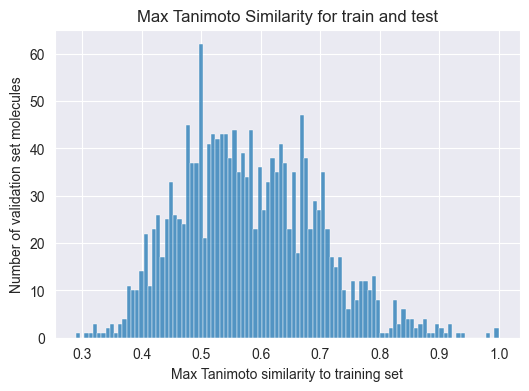

In [30]:
max_tanimoto_train_test = evaluate_split(
    df_split=df_combined,
    train_fold='train',
    val_fold='test',
    smiles_col='smiles',
    radius=2,
    n_bits=2048
)

Computing Morgan fingerprints for training set...
Computing Morgan fingerprints for validation set...
Computing maximum Tanimoto similarities for validation set...
Plotting histogram of maximum Tanimoto similarities...


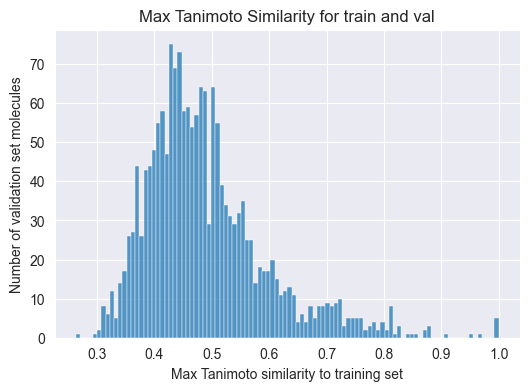

In [31]:
max_tanimoto_train_val = evaluate_split(
    df_split=df_combined,
    train_fold='train',
    val_fold='val',
    smiles_col='smiles',
    radius=2,
    n_bits=2048
)

In [32]:
df_orig_train = df_orig_us[df_orig_us['fold'] == 'train'].copy()
df_orig_train = df_orig_train[['smiles', 'fold', 'MurckoHist']]

In [33]:
df_combined_train = pd.concat([df_4M_train, df_orig_train], ignore_index=True)

In [34]:
print("Combined training dataset shape:", df_combined_train.shape)

Combined training dataset shape: (1883319, 7)


In [35]:
output_filename = "/Users/macbook/CODE/Majer:MassSpecGym/data/MSn/20241211_4M_murcko_train_smiles.tsv"
# df_combined_train.to_csv(output_filename, sep="\t", index=False)
print(f"Saved combined train smiles to {output_filename}")

Saved combined train smiles to /Users/macbook/CODE/Majer:MassSpecGym/data/MSn/20241211_4M_murcko_train_smiles.tsv
